<a href="https://colab.research.google.com/github/Danazzz/dataset-beras-scm/blob/main/SCM_Beras1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [346]:
# Import libraries
import pandas as pd
import zipfile, os
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = 15, 6            #agar semua plot ukurannya sama
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR

import xgboost

In [347]:
#Load data BI
converters = {
    'Beras': lambda x: str(x.replace(',', '')),
    'Beras Kualitas Bawah I' : lambda x: str(x.replace(',', '')),
    'Beras Kualitas Medium I' : lambda x: str(x.replace(',', '')),
    'Beras Kualitas Super I' : lambda x: str(x.replace(',', '')),
}

df1 = pd.read_csv('./csv/Tabel Harga Berdasarkan Daerah Jabar.csv', converters=converters)
df1

,Komoditas,Beras,Beras Kualitas Bawah I,Beras Kualitas Bawah II,Beras Kualitas Medium I,Beras Kualitas Medium II,Beras Kualitas Super I,Beras Kualitas Super II,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
0,01/ 01/ 2020,-,-,-,-,-,-,-,0,0,0
1,02/ 01/ 2020,11150,10100,9500,11350,10850,12900,12100,9800,11100,12500
2,03/ 01/ 2020,11150,10100,9500,11350,10850,12900,12100,9800,11100,12500
3,06/ 01/ 2020,11150,10150,9550,11350,10850,12900,12100,9850,11100,12500
4,07/ 01/ 2020,11200,10200,9650,11400,10900,12950,12150,9925,11150,12550
...,...,...,...,...,...,...,...,...,...,...,...
1093,11/ 03/ 2024,15800,14950,14500,16050,15550,17250,16550,14725,15800,16900
1094,12/ 03/ 2024,15800,14950,14500,16050,15550,17250,16550,14725,15800,16900
1095,13/ 03/ 2024,15750,14900,14400,16000,15450,17200,16550,14650,15725,16875
1096,14/ 03/ 2024,15750,14900,14400,16000,15450,17200,16550,14650,15725,16875


In [348]:
print('Data Types:')
print(df1.dtypes)

Data Types:
Komoditas                   object
Beras                       object
Beras Kualitas Bawah I      object
Beras Kualitas Bawah II     object
Beras Kualitas Medium I     object
Beras Kualitas Medium II    object
Beras Kualitas Super I      object
Beras Kualitas Super II     object
Beras Kualitas Bawah        object
Beras Kualitas Medium       object
Beras Kualitas Super        object
dtype: object


In [349]:
#Mengubah tanggal menjadi index
con=df1['Komoditas']
df1['Komoditas'] = pd.to_datetime(df1['Komoditas'], format='%d/ %m/ %Y')
df1.set_index('Komoditas', inplace=True)
#check datatype of index
df1.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07',
               '2024-03-08', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1098, freq=None)

In [350]:
df1 = df1.iloc[:, [0, 7, 8, 9]]
df1

,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,
2020-01-01,-,0,0,0
2020-01-02,11150,9800,11100,12500
2020-01-03,11150,9800,11100,12500
2020-01-06,11150,9850,11100,12500
2020-01-07,11200,9925,11150,12550
...,...,...,...,...
2024-03-11,15800,14725,15800,16900
2024-03-12,15800,14725,15800,16900
2024-03-13,15750,14650,15725,16875


In [351]:
# Mengubah - menjadi 0
df1.replace('-', np.nan, inplace=True)
df1.replace('#DIV/0!', np.nan, inplace=True)
df1

/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_42831/1513190452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('-', np.nan, inplace=True)
/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_42831/1513190452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('#DIV/0!', np.nan, inplace=True)


,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,
2020-01-01,NaN,0,0,0
2020-01-02,11150,9800,11100,12500
2020-01-03,11150,9800,11100,12500
2020-01-06,11150,9850,11100,12500
2020-01-07,11200,9925,11150,12550
...,...,...,...,...
2024-03-11,15800,14725,15800,16900
2024-03-12,15800,14725,15800,16900
2024-03-13,15750,14650,15725,16875


In [352]:
df1 = df1.astype('Int64')
df1

,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,
2020-01-01,<NA>,0,0,0
2020-01-02,11150,9800,11100,12500
2020-01-03,11150,9800,11100,12500
2020-01-06,11150,9850,11100,12500
2020-01-07,11200,9925,11150,12550
...,...,...,...,...
2024-03-11,15800,14725,15800,16900
2024-03-12,15800,14725,15800,16900
2024-03-13,15750,14650,15725,16875


In [353]:
df1.info()
df1.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1098 entries, 2020-01-01 to 2024-03-15
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Beras                  1050 non-null   Int64
 1   Beras Kualitas Bawah   1051 non-null   Int64
 2   Beras Kualitas Medium  1051 non-null   Int64
 3   Beras Kualitas Super   1051 non-null   Int64
dtypes: Int64(4)
memory usage: 47.2 KB


(1098, 4)

In [354]:
converters = {
    'Luas Panen Padi': lambda x: str(x.replace('.', '')),
    'GKP Tingkat Petani': lambda x: str(x.replace('.', '')),
    'GKP Tingkat Penggilingan' : lambda x: str(x.replace('.', '')),
    'GKG Tingkat Penggilingan' : lambda x: str(x.replace('.', '')),
    'Beras Medium Penggilingan' : lambda x: str(x.replace('.', '')),
    'Beras Premium Penggilingan' : lambda x: str(x.replace('.', '')),
}

#Load data
df2 = pd.read_csv('./csv/export-produsen-2.csv', converters=converters)
# print(df2.head())
df2

,Komoditas,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Ratarata Beras Penggilingan,Jagung Pipilan Kering,Kedelai Biji Kering (Lokal),Bawang Merah,Cabai Merah Keriting,Cabai Rawit Merah,Sapi (Hidup),Ayam Ras Pedaging (Hidup),Telur Ayam Ras,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
0,01/01/2020,20,3700,4000,4500,8200,9200,8700,-,-,-,-,-,-,-,-,600,150
1,02/01/2020,-,-,-,-,-,-,#DIV/0!,-,-,-,-,-,-,-,-,-,-
2,03/01/2020,-,-,-,-,-,-,#DIV/0!,-,-,-,-,-,-,-,-,-,-
3,04/01/2020,-,-,-,-,-,-,#DIV/0!,-,-,-,-,-,-,-,-,-,-
4,05/01/2020,-,-,-,-,-,-,#DIV/0!,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,11/03/2024,10,6760,7140,8330,14180,15640,14910,5540,10610,15990,41880,45050,54440,24480,27540,120,80
1532,12/03/2024,10,6530,6930,8260,14140,15480,14810,5250,10610,16330,42830,43390,54470,24480,28260,120,80
1533,13/03/2024,10,6480,6920,8240,14040,15460,14750,5280,10310,15990,43770,42270,54560,24000,28200,100,60
1534,14/03/2024,10,6510,7060,8240,14050,15510,14780,5280,10310,15840,45070,41840,54550,24010,28130,150,70


PRODUSEN
Panel Harga Pangan pada tingkat produsen yang diamati meliputi:
- Luas Lahan/Sawah Padi, persentase (%) luas panen Padi di kecamatan sentra produksi.
- GKP Tingkat Petani, harga di Petani (Rp/Kg)
- GKP Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- GKG Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Beras Medium Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Beras Premium Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Stok GKG Tingkat Penggilingan, stok dalam satuan Kwintal
- Stok Beras Tingkat Penggilingan, stok dalam satuan Kwintal

In [355]:
print('Data Types:')
print(df2.dtypes)

Data Types:
Komoditas                          object
Luas Panen Padi                    object
GKP Tingkat Petani                 object
GKP Tingkat Penggilingan           object
GKG Tingkat Penggilingan           object
Beras Medium Penggilingan          object
Beras Premium Penggilingan         object
Ratarata Beras Penggilingan        object
Jagung Pipilan Kering              object
Kedelai Biji Kering (Lokal)        object
Bawang Merah                       object
Cabai Merah Keriting               object
Cabai Rawit Merah                  object
Sapi (Hidup)                       object
Ayam Ras Pedaging (Hidup)          object
Telur Ayam Ras                     object
Stok GKG Tingkat Penggilingan      object
Stok Beras Tingkat Penggilingan    object
dtype: object


In [356]:
#Mengubah tanggal menjadi index
con=df2['Komoditas']
df2['Komoditas'] = pd.to_datetime(df2['Komoditas'], format='%d/%m/%Y')
df2.set_index('Komoditas', inplace=True)
#check datatype of index
df2.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
               '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1536, freq=None)

In [357]:
print(df2.columns)

Index(['Luas Panen Padi', 'GKP Tingkat Petani', 'GKP Tingkat Penggilingan',
       'GKG Tingkat Penggilingan', 'Beras Medium Penggilingan',
       'Beras Premium Penggilingan', 'Ratarata Beras Penggilingan',
       'Jagung Pipilan Kering', 'Kedelai Biji Kering (Lokal)', 'Bawang Merah',
       'Cabai Merah Keriting', 'Cabai Rawit Merah', 'Sapi (Hidup)',
       'Ayam Ras Pedaging (Hidup)', 'Telur Ayam Ras',
       'Stok GKG Tingkat Penggilingan', 'Stok Beras Tingkat Penggilingan'],
      dtype='object')


In [358]:
df2 = df2.iloc[:, [0, 1, 2, 3, 6, 15, 16]]
df2

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,
2020-01-01,20,3700,4000,4500,8700,600,150
2020-01-02,-,-,-,-,#DIV/0!,-,-
2020-01-03,-,-,-,-,#DIV/0!,-,-
2020-01-04,-,-,-,-,#DIV/0!,-,-
2020-01-05,-,-,-,-,#DIV/0!,-,-
...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80
2024-03-12,10,6530,6930,8260,14810,120,80
2024-03-13,10,6480,6920,8240,14750,100,60


In [359]:
# Mengubah - menjadi 0
df2.replace('-', np.nan, inplace=True)
df2.replace('#DIV/0!', np.nan, inplace=True)
df2

/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_42831/1801948625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace('-', np.nan, inplace=True)
/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_42831/1801948625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace('#DIV/0!', np.nan, inplace=True)


,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,
2020-01-01,20,3700,4000,4500,8700,600,150
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80
2024-03-12,10,6530,6930,8260,14810,120,80
2024-03-13,10,6480,6920,8240,14750,100,60


In [360]:
# ini datanya ada yang gajelas 1
# luas panen 20710?
df2 = df2.drop(df2[df2['Luas Panen Padi'] == '20710'].index)

In [361]:
df2 = df2.astype('Int64')
df2

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,
2020-01-01,20,3700,4000,4500,8700,600,150
2020-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80
2024-03-12,10,6530,6930,8260,14810,120,80
2024-03-13,10,6480,6920,8240,14750,100,60


In [362]:
df2.info()
df2.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1535 entries, 2020-01-01 to 2024-03-15
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  1072 non-null   Int64
 1   GKP Tingkat Petani               1073 non-null   Int64
 2   GKP Tingkat Penggilingan         1073 non-null   Int64
 3   GKG Tingkat Penggilingan         1075 non-null   Int64
 4   Ratarata Beras Penggilingan      1075 non-null   Int64
 5   Stok GKG Tingkat Penggilingan    1063 non-null   Int64
 6   Stok Beras Tingkat Penggilingan  1063 non-null   Int64
dtypes: Int64(7)
memory usage: 106.4 KB


(1535, 7)

In [363]:
df3 = pd.merge(df2, df1, on='Komoditas', how='left')
df3

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,,,,,,,,
2020-01-01,20,3700,4000,4500,8700,600,150,<NA>,0,0,0
2020-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11150,9800,11100,12500
2020-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11150,9800,11100,12500
2020-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80,15800,14725,15800,16900
2024-03-12,10,6530,6930,8260,14810,120,80,15800,14725,15800,16900
2024-03-13,10,6480,6920,8240,14750,100,60,15750,14650,15725,16875


In [364]:
df3.info()
df3.nunique()

# Menampilkan nilai unik dalam setiap kolom
for col in df3.columns:
    unique_values = df3[col].unique()
    print(f"Nilai unik dalam kolom {col}: {unique_values}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1535 entries, 2020-01-01 to 2024-03-15
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  1072 non-null   Int64
 1   GKP Tingkat Petani               1073 non-null   Int64
 2   GKP Tingkat Penggilingan         1073 non-null   Int64
 3   GKG Tingkat Penggilingan         1075 non-null   Int64
 4   Ratarata Beras Penggilingan      1075 non-null   Int64
 5   Stok GKG Tingkat Penggilingan    1063 non-null   Int64
 6   Stok Beras Tingkat Penggilingan  1063 non-null   Int64
 7   Beras                            1049 non-null   Int64
 8   Beras Kualitas Bawah             1050 non-null   Int64
 9   Beras Kualitas Medium            1050 non-null   Int64
 10  Beras Kualitas Super             1050 non-null   Int64
dtypes: Int64(11)
memory usage: 160.4 KB
Nilai unik dalam kolom Luas Panen Padi: <IntegerArray>

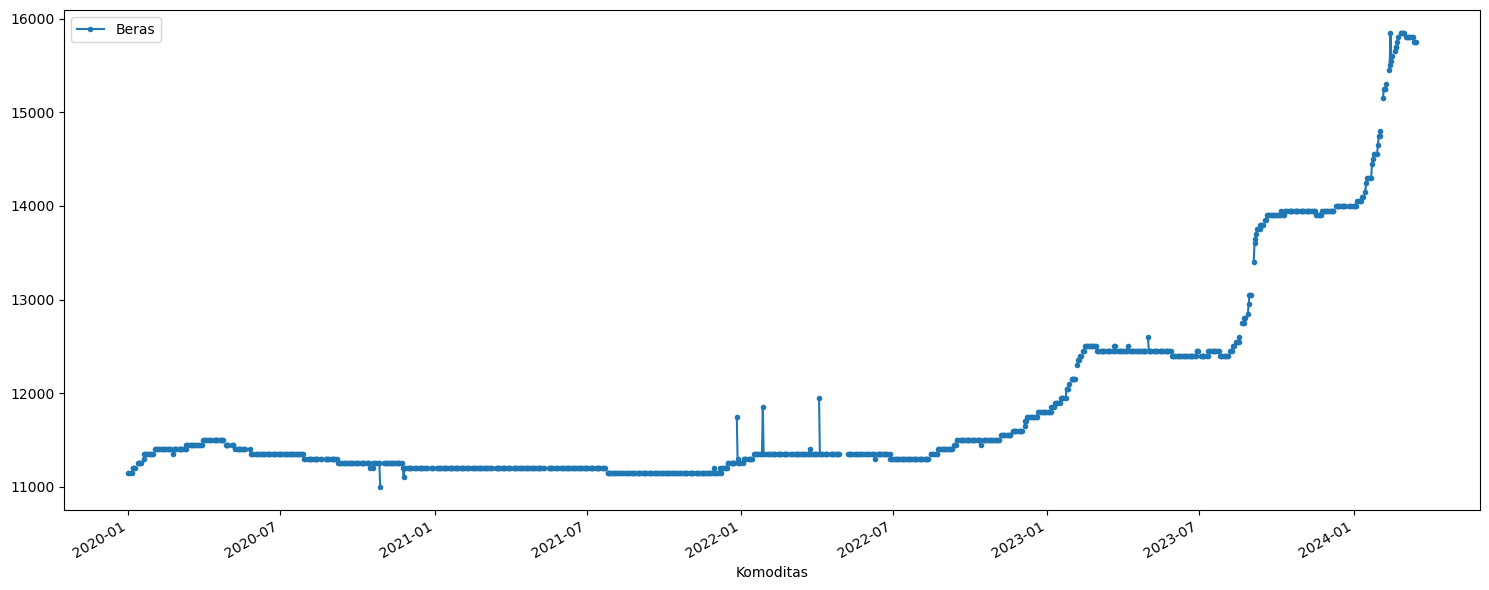

In [365]:
# plt.plot(df3)
df3[['Beras']].plot(style='.-', use_index=True)
# df3[['GKP Tingkat Petani']].loc['2020-01-01':'2024-03-01'].plot(style='.-')
plt.tight_layout()
plt.show()

In [366]:
# Clean dataset df3 from NaN
df3 = df3.dropna()
df3

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super
Komoditas,,,,,,,,,,,
2021-03-15,10,4000,4150,5050,9465,20,10,11200,9800,11150,12650
2021-03-16,10,3850,4100,4740,9360,70,20,11200,9800,11150,12650
2021-03-17,10,4160,4230,4950,9400,30,10,11200,9800,11150,12650
2021-03-18,10,4120,4190,4730,9340,40,10,11200,9775,11175,12650
2021-03-19,10,4190,4290,4990,9410,40,10,11200,9800,11150,12650
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80,15800,14725,15800,16900
2024-03-12,10,6530,6930,8260,14810,120,80,15800,14725,15800,16900
2024-03-13,10,6480,6920,8240,14750,100,60,15750,14650,15725,16875


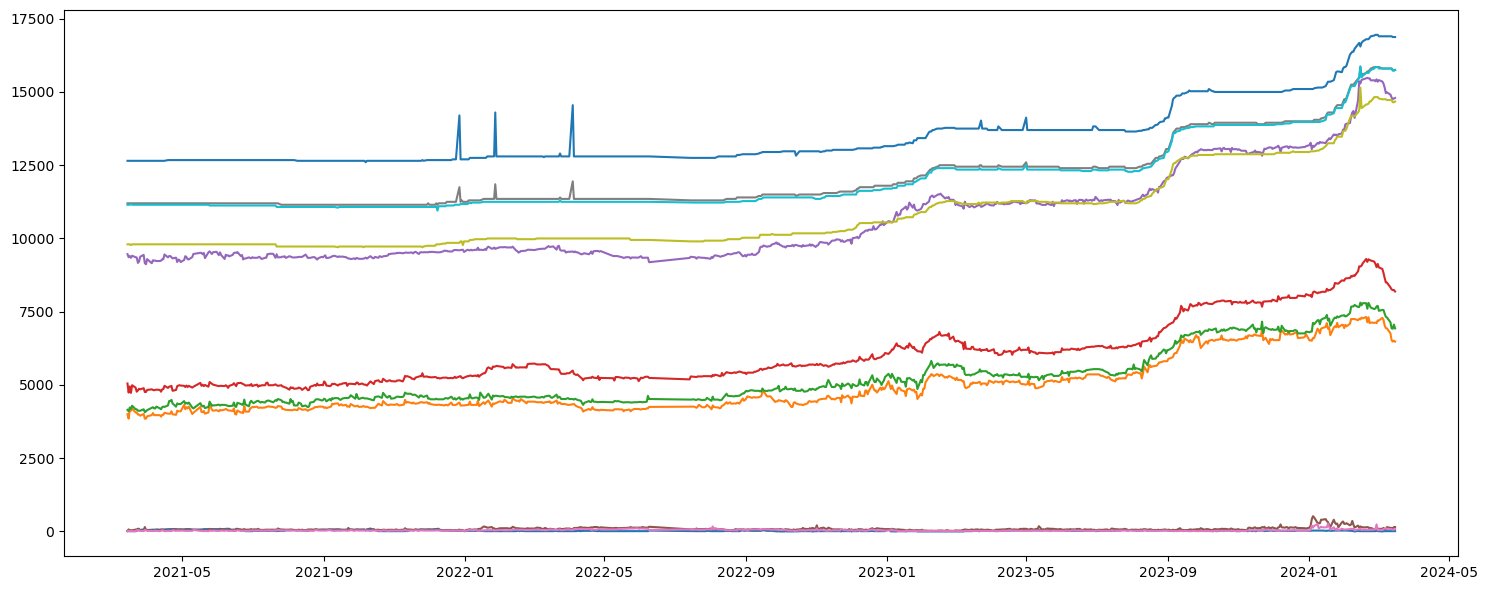

In [367]:
plt.plot(df3)
# df3[['GKP Tingkat Petani']].plot(style='.-', use_index=True)
# df3[['GKP Tingkat Petani']].loc['2020-01-01':'2024-03-01'].plot(style='.-')
plt.tight_layout()
plt.show()

In [368]:
#is the dataset df3 ready for time series analysis?
df3.info()
df3.nunique()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2021-03-15 to 2024-03-15
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  733 non-null    Int64
 1   GKP Tingkat Petani               733 non-null    Int64
 2   GKP Tingkat Penggilingan         733 non-null    Int64
 3   GKG Tingkat Penggilingan         733 non-null    Int64
 4   Ratarata Beras Penggilingan      733 non-null    Int64
 5   Stok GKG Tingkat Penggilingan    733 non-null    Int64
 6   Stok Beras Tingkat Penggilingan  733 non-null    Int64
 7   Beras                            733 non-null    Int64
 8   Beras Kualitas Bawah             733 non-null    Int64
 9   Beras Kualitas Medium            733 non-null    Int64
 10  Beras Kualitas Super             733 non-null    Int64
dtypes: Int64(11)
memory usage: 76.6 KB


Luas Panen Padi                     11
GKP Tingkat Petani                 209
GKP Tingkat Penggilingan           226
GKG Tingkat Penggilingan           252
Ratarata Beras Penggilingan        332
Stok GKG Tingkat Penggilingan       37
Stok Beras Tingkat Penggilingan     20
Beras                               65
Beras Kualitas Bawah                96
Beras Kualitas Medium               83
Beras Kualitas Super                83
dtype: int64

In [369]:
df4 = pd.read_csv('./csv/distributor_pembelian.csv')
df4

,Komoditas,UMP,BBM Solar,quantity
0,01/01/2020,"1,810,351","9,500","113,151"
1,02/01/2020,"1,810,351","9,500","113,151"
2,03/01/2020,"1,810,351","9,500","113,151"
3,04/01/2020,"1,810,351","9,500","113,151"
4,05/01/2020,"1,810,351","9,500","113,151"
...,...,...,...,...
1531,11/03/2024,"2,057,495","6,800","113,151"
1532,12/03/2024,"2,057,495","6,800","113,151"
1533,13/03/2024,"2,057,495","6,800","113,151"
1534,14/03/2024,"2,057,495","6,800","113,151"


In [370]:
#delete all commas in the data
df4['UMP'] = df4['UMP'].str.replace(',', '')
df4['BBM Solar'] = df4['BBM Solar'].str.replace(',', '')
df4['quantity'] = df4['quantity'].str.replace(',', '')
df4

,Komoditas,UMP,BBM Solar,quantity
0,01/01/2020,1810351,9500,113151
1,02/01/2020,1810351,9500,113151
2,03/01/2020,1810351,9500,113151
3,04/01/2020,1810351,9500,113151
4,05/01/2020,1810351,9500,113151
...,...,...,...,...
1531,11/03/2024,2057495,6800,113151
1532,12/03/2024,2057495,6800,113151
1533,13/03/2024,2057495,6800,113151
1534,14/03/2024,2057495,6800,113151


In [371]:
#Mengubah tanggal menjadi index
con=df4['Komoditas']
df4['Komoditas'] = pd.to_datetime(df4['Komoditas'], format='%d/%m/%Y')
df4.set_index('Komoditas', inplace=True)
#check datatype of index
df4.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
               '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1536, freq=None)

In [372]:
df4 = df4.astype('Int64')
df4

,UMP,BBM Solar,quantity
Komoditas,,,
2020-01-01,1810351,9500,113151
2020-01-02,1810351,9500,113151
2020-01-03,1810351,9500,113151
2020-01-04,1810351,9500,113151
2020-01-05,1810351,9500,113151
...,...,...,...
2024-03-11,2057495,6800,113151
2024-03-12,2057495,6800,113151
2024-03-13,2057495,6800,113151


In [373]:
df5 = pd.merge(df3, df4, on='Komoditas', how='left')
df5

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super,UMP,BBM Solar,quantity
Komoditas,,,,,,,,,,,,,,
2021-03-15,10,4000,4150,5050,9465,20,10,11200,9800,11150,12650,1810351,9600,113151
2021-03-16,10,3850,4100,4740,9360,70,20,11200,9800,11150,12650,1810351,9600,113151
2021-03-17,10,4160,4230,4950,9400,30,10,11200,9800,11150,12650,1810351,9600,113151
2021-03-18,10,4120,4190,4730,9340,40,10,11200,9775,11175,12650,1810351,9600,113151
2021-03-19,10,4190,4290,4990,9410,40,10,11200,9800,11150,12650,1810351,9600,113151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14910,120,80,15800,14725,15800,16900,2057495,6800,113151
2024-03-12,10,6530,6930,8260,14810,120,80,15800,14725,15800,16900,2057495,6800,113151
2024-03-13,10,6480,6920,8240,14750,100,60,15750,14650,15725,16875,2057495,6800,113151


In [374]:
df5.nunique()

Luas Panen Padi                     11
GKP Tingkat Petani                 209
GKP Tingkat Penggilingan           226
GKG Tingkat Penggilingan           252
Ratarata Beras Penggilingan        332
Stok GKG Tingkat Penggilingan       37
Stok Beras Tingkat Penggilingan     20
Beras                               65
Beras Kualitas Bawah                96
Beras Kualitas Medium               83
Beras Kualitas Super                83
UMP                                  4
BBM Solar                            3
quantity                             1
dtype: int64

In [375]:
df5.corr()

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah,Beras Kualitas Medium,Beras Kualitas Super,UMP,BBM Solar,quantity
Luas Panen Padi,1.000000,-0.164905,-0.193517,-0.248987,-0.184377,-0.121772,-0.202656,-0.183241,-0.184215,-0.175557,-0.184913,-0.228584,0.295987,NaN
GKP Tingkat Petani,-0.164905,1.000000,0.994734,0.985025,0.976199,0.444965,0.149439,0.973301,0.977386,0.972349,0.961590,0.870927,-0.523155,NaN
GKP Tingkat Penggilingan,-0.193517,0.994734,1.000000,0.990028,0.979224,0.442201,0.155998,0.976628,0.980254,0.975468,0.965921,0.873654,-0.505861,NaN
GKG Tingkat Penggilingan,-0.248987,0.985025,0.990028,1.000000,0.982479,0.455465,0.182008,0.978937,0.981946,0.977152,0.969887,0.881153,-0.554359,NaN
Ratarata Beras Penggilingan,-0.184377,0.976199,0.979224,0.982479,1.000000,0.393384,0.123216,0.991972,0.994028,0.991625,0.983144,0.906697,-0.552020,NaN
Stok GKG Tingkat Penggilingan,-0.121772,0.444965,0.442201,0.455465,0.393384,1.000000,0.698509,0.427691,0.426235,0.427292,0.429639,0.336361,-0.279596,NaN
Stok Beras Tingkat Penggilingan,-0.202656,0.149439,0.155998,0.182008,0.123216,0.698509,1.000000,0.172808,0.164300,0.172802,0.186633,0.056631,-0.143843,NaN
Beras,-0.183241,0.973301,0.976628,0.978937,0.991972,0.427691,0.172808,1.000000,0.998726,0.999387,0.996205,0.875405,-0.540143,NaN
Beras Kualitas Bawah,-0.184215,0.977386,0.980254,0.981946,0.994028,0.426235,0.164300,0.998726,1.000000,0.998661,0.991112,0.885970,-0.550686,NaN
Beras Kualitas Medium,-0.175557,0.972349,0.975468,0.977152,0.991625,0.427292,0.172802,0.999387,0.998661,1.000000,0.994003,0.872179,-0.536578,NaN


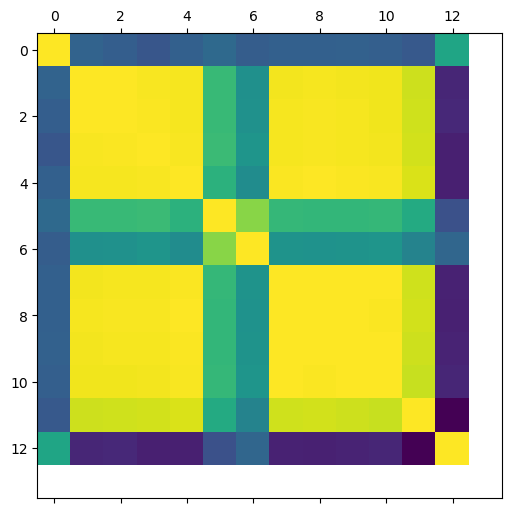

In [376]:
#and then plot the correlation
plt.matshow(df5.corr())
plt.show()


In [377]:
df5.corr()['Beras'].sort_values(ascending=False)

Beras                              1.000000
Beras Kualitas Medium              0.999387
Beras Kualitas Bawah               0.998726
Beras Kualitas Super               0.996205
Ratarata Beras Penggilingan        0.991972
GKG Tingkat Penggilingan           0.978937
GKP Tingkat Penggilingan           0.976628
GKP Tingkat Petani                 0.973301
UMP                                0.875405
Stok GKG Tingkat Penggilingan      0.427691
Stok Beras Tingkat Penggilingan    0.172808
Luas Panen Padi                   -0.183241
BBM Solar                         -0.540143
quantity                                NaN
Name: Beras, dtype: float64

In [378]:
#drop column Beras Kualitas Bawah I, Beras Kualitas Medium I, Beras Kualitas Super I
df5 = df5.drop(['Beras Kualitas Bawah', 'Beras Kualitas Medium', 'Beras Kualitas Super'], axis=1)

Accuracy: 0.7278911564625851


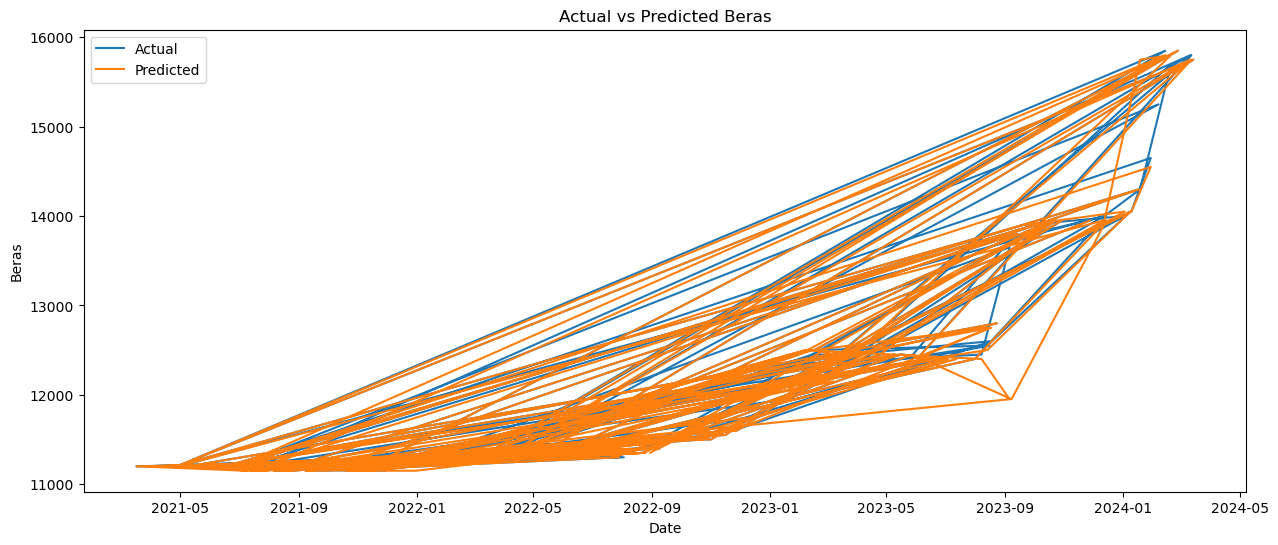

In [379]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Prepare the features and target variables
X = df5.drop('Beras', axis=1)
y = df5['Beras']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Visualize the actual and predicted values
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Beras')
plt.title('Actual vs Predicted Beras')
plt.legend()
plt.show()

In [380]:
#evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     11150.0       0.62      1.00      0.76        13
     11200.0       1.00      0.72      0.84        25
     11250.0       0.00      0.00      0.00         2
     11300.0       0.75      0.50      0.60         6
     11350.0       0.80      1.00      0.89        24
     11400.0       1.00      0.33      0.50         6
     11500.0       1.00      1.00      1.00         7
     11550.0       1.00      1.00      1.00         2
     11600.0       1.00      1.00      1.00         2
     11750.0       1.00      1.00      1.00         2
     11900.0       1.00      1.00      1.00         2
     11950.0       0.00      0.00      0.00         1
     12050.0       0.00      0.00      0.00         0
     12150.0       0.00      0.00      0.00         0
     12350.0       0.00      0.00      0.00         2
     12400.0       0.75      0.86      0.80         7
     12450.0       1.00      0.73      0.85        15
     12500.0       0.17    

/Library/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/miniconda3/lib/python3.11/site-packa

In [381]:
# Predict the price of Beras for the next 30 days
y_pred = model.predict(X_test)

# Print the predicted prices
print(y_pred)


[13950. 11200. 11350. 11250. 11550. 11150. 11200. 12450. 12750. 11600.
 11350. 11400. 14050. 14550. 11200. 11150. 11200. 11350. 12400. 12450.
 11350. 11350. 11350. 11200. 11200. 12400. 11150. 11350. 11350. 15850.
 11150. 11500. 11350. 11150. 12450. 12500. 11350. 13950. 11350. 11200.
 11150. 11500. 12450. 11950. 13950. 12400. 11350. 12400. 12450. 11300.
 12400. 11900. 11600. 11350. 12500. 11350. 11350. 11350. 12500. 12400.
 11950. 11300. 11150. 11500. 11750. 11300. 12450. 12800. 11200. 13950.
 11150. 11200. 11400. 11150. 11350. 11150. 13800. 11350. 11200. 11350.
 15750. 11150. 11350. 12450. 15800. 15750. 13950. 11500. 11500. 11150.
 11200. 13900. 14050. 11900. 15750. 12400. 12750. 12500. 13950. 11750.
 11550. 11350. 11350. 11150. 11150. 11350. 12150. 11350. 15800. 11200.
 15750. 11350. 12450. 13950. 12500. 11350. 11200. 11150. 11150. 11500.
 11150. 12400. 11500. 11150. 11200. 11300. 11150. 11350. 12450. 11200.
 12500. 14050. 11350. 12450. 13950. 12050. 11150. 12450. 11350. 11200.
 14300

AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'